# 🛡️ SecureMind AI — CICIDS2017 Data Preprocessing Pipeline


**Pipeline Overview:**
1. **Load & Merge** 
2. **Initial Cleaning** 
3. **Label Grouping** 
4. **Feature Selection**
5. **Feature Importance** — Evaluate with Kruskal-Wallis H-test and remove irrelevant features
6. **Scaling** 
7. **Label Encoding** 
8. **Train/Test Split** 
9. **Export**

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Helper Functions

Reusable utilities extracted from all three source notebooks.

In [2]:
def clean_dataset(df):
    """Remove rows containing NaN, inf, or -inf values."""
    assert isinstance(df, pd.DataFrame), "Input must be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep]


def get_feature_types(df, target_col='Attack Type'):
    """Identify numeric and categorical feature columns, excluding the target."""
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    for col_list in [numeric_features, categorical_features]:
        if target_col in col_list:
            col_list.remove(target_col)
    return numeric_features, categorical_features


def find_identical_columns(df):
    """Find groups of columns that contain identical data."""
    identical_columns = {}
    columns = df.columns.tolist()
    checked = set()
    for i, col1 in enumerate(columns):
        if col1 in checked:
            continue
        for col2 in columns[i + 1:]:
            if col2 in checked:
                continue
            if df[col1].equals(df[col2]):
                identical_columns.setdefault(col1, []).append(col2)
                checked.add(col2)
    return identical_columns


def calculate_outliers_percentage(df):
    """Calculate the percentage of outliers per column using the IQR method."""
    outlier_pcts = {}
    for col in df.columns:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
        outlier_pcts[col] = len(outliers) / len(df) * 100
    return outlier_pcts


print("✅ Helper functions defined")

✅ Helper functions defined


## 3. Load & Merge Dataset

Load all CICIDS2017 CSV files from the data directory and merge them into a single DataFrame.

> **📁 Update `DATA_DIR`** below to point to your local folder containing the CICIDS2017 CSV files.

In [ ]:
DATA_DIR = 'data/' 
dfs = []
for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        if filename.endswith('.csv'):
            filepath = os.path.join(dirname, filename)
            dfs.append(pd.read_csv(filepath))
            print(f"  Loaded: {filename}  →  {dfs[-1].shape}")

# Merge 
data = pd.concat(dfs, axis=0, ignore_index=True)
del dfs  # free memory

print(f"\n✅ Merged dataset shape: {data.shape}")
data.head()

  Loaded: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  →  (170366, 79)
  Loaded: Friday-WorkingHours-Morning.pcap_ISCX.csv  →  (191033, 79)
  Loaded: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  →  (288602, 79)
  Loaded: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  →  (286467, 79)
  Loaded: Monday-WorkingHours.pcap_ISCX.csv  →  (529918, 79)
  Loaded: Wednesday-workingHours.pcap_ISCX.csv  →  (692703, 79)
  Loaded: Tuesday-WorkingHours.pcap_ISCX.csv  →  (445909, 79)
  Loaded: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  →  (225745, 79)

✅ Merged dataset shape: (2830743, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,389,113095465,48,24,9668,10012,403,0,201.416667,203.548293,...,32,203985.500,5.758373e+05,1629110,379,13800000.0,4.277541e+06,16500000,6737603,BENIGN
1,389,113473706,68,40,11364,12718,403,0,167.117647,171.919413,...,32,178326.875,5.034269e+05,1424245,325,13800000.0,4.229413e+06,16500000,6945512,BENIGN
2,0,119945515,150,0,0,0,0,0,0.000000,0.000000,...,0,6909777.333,1.170000e+07,20400000,6,24400000.0,2.430000e+07,60100000,5702188,BENIGN
3,443,60261928,9,7,2330,4221,1093,0,258.888889,409.702161,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,53,269,2,2,102,322,51,51,51.000000,0.000000,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


## 4. Initial Cleaning

- Strip whitespace from column names
- Remove duplicate rows
- Remove columns with identical data
- Replace `inf` / `-inf` with `NaN`, then drop rows with `NaN`

In [ ]:
data.columns = data.columns.str.strip()
print(f"Columns after stripping: {len(data.columns)}")

before = len(data)
data.drop_duplicates(keep='first', inplace=True)
print(f"Removed {before - len(data):,} duplicate rows  →  {data.shape[0]:,} rows remaining")

# 4.3 Remove columns with identical data
identical_cols = find_identical_columns(data)
if identical_cols:
    print("\nIdentical column groups found:")
    for key, dupes in identical_cols.items():
        print(f"  '{key}' is identical to {dupes}")
        data.drop(columns=dupes, inplace=True)
else:
    print("\nNo identical columns found.")

# 4.4 Replace inf → NaN, then drop NaN rows
data.replace([np.inf, -np.inf], np.nan, inplace=True)
before = len(data)
data.dropna(inplace=True)
print(f"Dropped {before - len(data):,} rows with NaN/inf  →  {data.shape[0]:,} rows remaining")

# Reset index
data.reset_index(drop=True, inplace=True)

print(f"\n✅ Cleaned dataset shape: {data.shape}")

Columns after stripping: 79
Removed 308,381 duplicate rows  →  2,522,362 rows remaining
Removed 308,381 duplicate rows  →  2,522,362 rows remaining

Identical column groups found:
  'Total Fwd Packets' is identical to ['Subflow Fwd Packets']

Identical column groups found:
  'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
  'Total Backward Packets' is identical to ['Subflow Bwd Packets']
  'Total Backward Packets' is identical to ['Subflow Bwd Packets']
  'Fwd PSH Flags' is identical to ['SYN Flag Count']
  'Fwd PSH Flags' is identical to ['SYN Flag Count']
  'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
  'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
  'Fwd URG Flags' is identical to ['CWE Flag Count']

## 5. Label Grouping & Rare Class Removal

Group the fine-grained `Label` column into broader attack categories and remove classes with very few samples (`Infiltration`, `Heartbleed`) which can cause overfitting.

In [5]:
# 5.1 Map fine-grained labels → broader categories
group_mapping = {
    'BENIGN':                       'Normal Traffic',
    'DoS Hulk':                     'DoS',
    'DDoS':                         'DDoS',
    'PortScan':                     'Port Scanning',
    'DoS GoldenEye':                'DoS',
    'FTP-Patator':                  'Brute Force',
    'DoS slowloris':                'DoS',
    'DoS Slowhttptest':             'DoS',
    'SSH-Patator':                  'Brute Force',
    'Bot':                          'Bots',
    'Web Attack \x96 Brute Force':  'Web Attacks',
    'Web Attack \x96 XSS':         'Web Attacks',
    'Infiltration':                 'Infiltration',
    'Web Attack \x96 Sql Injection':'Web Attacks',
    'Heartbleed':                   'Miscellaneous',
}

data['Attack Type'] = data['Label'].map(group_mapping)

# Handle any unmapped labels (keep original if not in mapping)
unmapped = data['Attack Type'].isna().sum()
if unmapped > 0:
    print(f"⚠️  {unmapped} rows had unmapped labels — filling with original Label")
    data['Attack Type'].fillna(data['Label'], inplace=True)

# Drop the original fine-grained Label column
data.drop(columns='Label', inplace=True)

# 5.2 Remove rare classes
rare_classes = ['Infiltration', 'Miscellaneous']
before = len(data)
data = data[~data['Attack Type'].isin(rare_classes)]
print(f"Removed {before - len(data):,} rows from rare classes {rare_classes}")

# Show class distribution
print("\n📊 Class distribution:")
print(data['Attack Type'].value_counts())
print(f"\n✅ Dataset shape after label grouping: {data.shape}")

⚠️  2143 rows had unmapped labels — filling with original Label
Removed 47 rows from rare classes ['Infiltration', 'Miscellaneous']

📊 Class distribution:
Attack Type
Normal Traffic                2095057
DoS                            193745
DDoS                           128014
Port Scanning                   90694
Brute Force                      9150
Bots                             1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Web Attack � Sql Injection         21
Name: count, dtype: int64

✅ Dataset shape after label grouping: (2520751, 67)
Removed 47 rows from rare classes ['Infiltration', 'Miscellaneous']

📊 Class distribution:
Attack Type
Normal Traffic                2095057
DoS                            193745
DDoS                           128014
Port Scanning                   90694
Brute Force                      9150
Bots                             1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Web A

## 6. Feature Selection

### 6.1 Remove single-value columns
Columns with only one unique value carry no information.

### 6.2 Remove highly correlated features
Features with near-perfect multicollinearity (|correlation| ≥ 0.95) are redundant — remove one from each pair.

In [6]:
# 6.1 Remove columns with only one unique value
single_val_cols = [col for col in data.columns if data[col].nunique() == 1]
if single_val_cols:
    print(f"Dropping {len(single_val_cols)} single-value columns: {single_val_cols}")
    data.drop(columns=single_val_cols, inplace=True)
else:
    print("No single-value columns found.")

# 6.2 Remove highly correlated features (|r| >= 0.95)
numeric_features, _ = get_feature_types(data)
corr_matrix = data[numeric_features].corr().abs()

# Extract upper triangle pairs above threshold
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = set()
for col in upper_tri.columns:
    highly_corr = upper_tri.index[upper_tri[col] >= 0.95].tolist()
    if highly_corr:
        to_drop_corr.add(col)

if to_drop_corr:
    print(f"\nDropping {len(to_drop_corr)} highly correlated features:\n  {sorted(to_drop_corr)}")
    data.drop(columns=to_drop_corr, inplace=True)
else:
    print("\nNo highly correlated feature pairs found.")

print(f"\n✅ Dataset shape after feature selection: {data.shape}")

Dropping 1 single-value columns: ['Bwd PSH Flags']

Dropping 18 highly correlated features:
  ['Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'ECE Flag Count', 'Fwd IAT Max', 'Fwd IAT Total', 'Fwd Packet Length Std', 'Fwd Packets/s', 'Idle Max', 'Idle Mean', 'Idle Min', 'Packet Length Std', 'Subflow Bwd Bytes', 'Subflow Fwd Bytes', 'Total Backward Packets', 'Total Length of Bwd Packets']

Dropping 18 highly correlated features:
  ['Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'ECE Flag Count', 'Fwd IAT Max', 'Fwd IAT Total', 'Fwd Packet Length Std', 'Fwd Packets/s', 'Idle Max', 'Idle Mean', 'Idle Min', 'Packet Length Std', 'Subflow Bwd Bytes', 'Subflow Fwd Bytes', 'Total Backward Packets', 'Total Length of Bwd Packets']

✅ Dataset shape after feature selection: (2520751, 48)

✅ Dataset shape after feature selection: (2520751, 48)


## 7. Feature Importance — Kruskal-Wallis H-Test

Since the data is non-normally distributed with unequal variances, the **Kruskal-Wallis** test (non-parametric) is used to evaluate feature importance. Features with very low H-statistics and high p-values are statistically irrelevant.

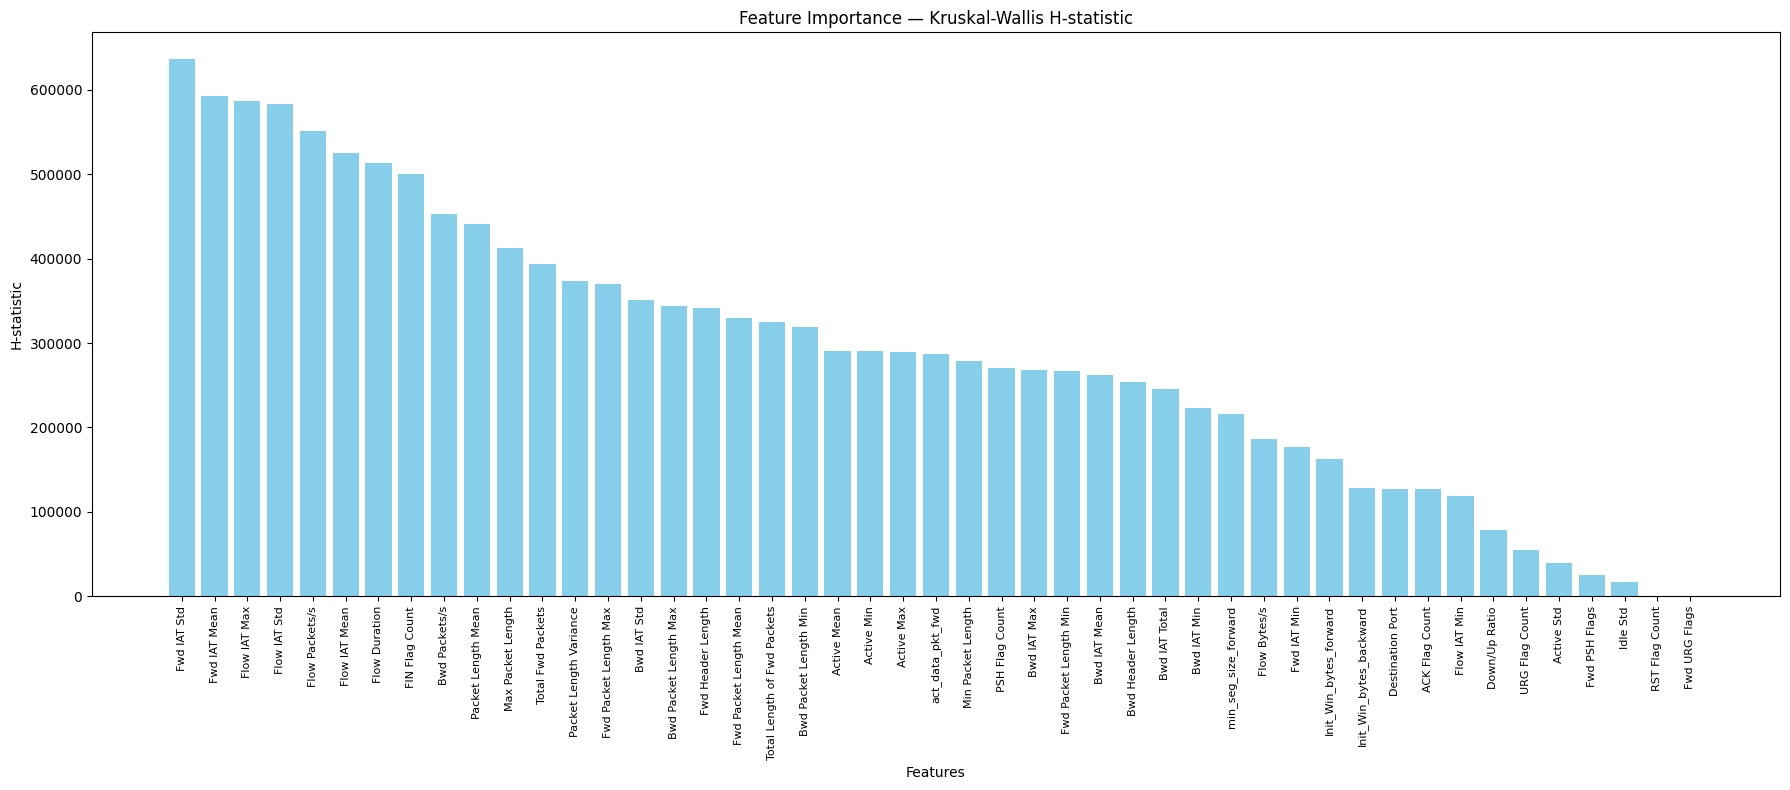


All features are statistically significant (p ≤ 0.05).

✅ Dataset shape after feature importance filtering: (2520751, 48)


In [7]:
# Kruskal-Wallis H-test for each numeric feature
numeric_features, _ = get_feature_types(data)
target_col = 'Attack Type'

h_scores = {}
for feature in numeric_features:
    groups = [group[feature].dropna().values for _, group in data.groupby(target_col)]
    h_stat, p_val = stats.kruskal(*groups)
    h_scores[feature] = {'H-statistic': h_stat, 'p-value': p_val}

h_df = pd.DataFrame.from_dict(h_scores, orient='index').sort_values('H-statistic', ascending=False)

# Visualize
plt.figure(figsize=(18, 8))
plt.bar(range(len(h_df)), h_df['H-statistic'], color='skyblue')
plt.xticks(range(len(h_df)), h_df.index, rotation=90, fontsize=8)
plt.title('Feature Importance — Kruskal-Wallis H-statistic')
plt.xlabel('Features')
plt.ylabel('H-statistic')
plt.tight_layout()
plt.show()

# Drop features with p-value > 0.05 (not statistically significant)
irrelevant = h_df[h_df['p-value'] > 0.05].index.tolist()
if irrelevant:
    print(f"\nDropping {len(irrelevant)} statistically irrelevant features (p > 0.05): {irrelevant}")
    data.drop(columns=irrelevant, inplace=True)
else:
    print("\nAll features are statistically significant (p ≤ 0.05).")

print(f"\n✅ Dataset shape after feature importance filtering: {data.shape}")

## 8. Outlier Analysis (Informational)

Visualize outlier percentages per feature using the IQR method. Outliers are **not removed** here, but the information is useful for choosing robust models or applying transformations later.

<Figure size 1800x600 with 0 Axes>

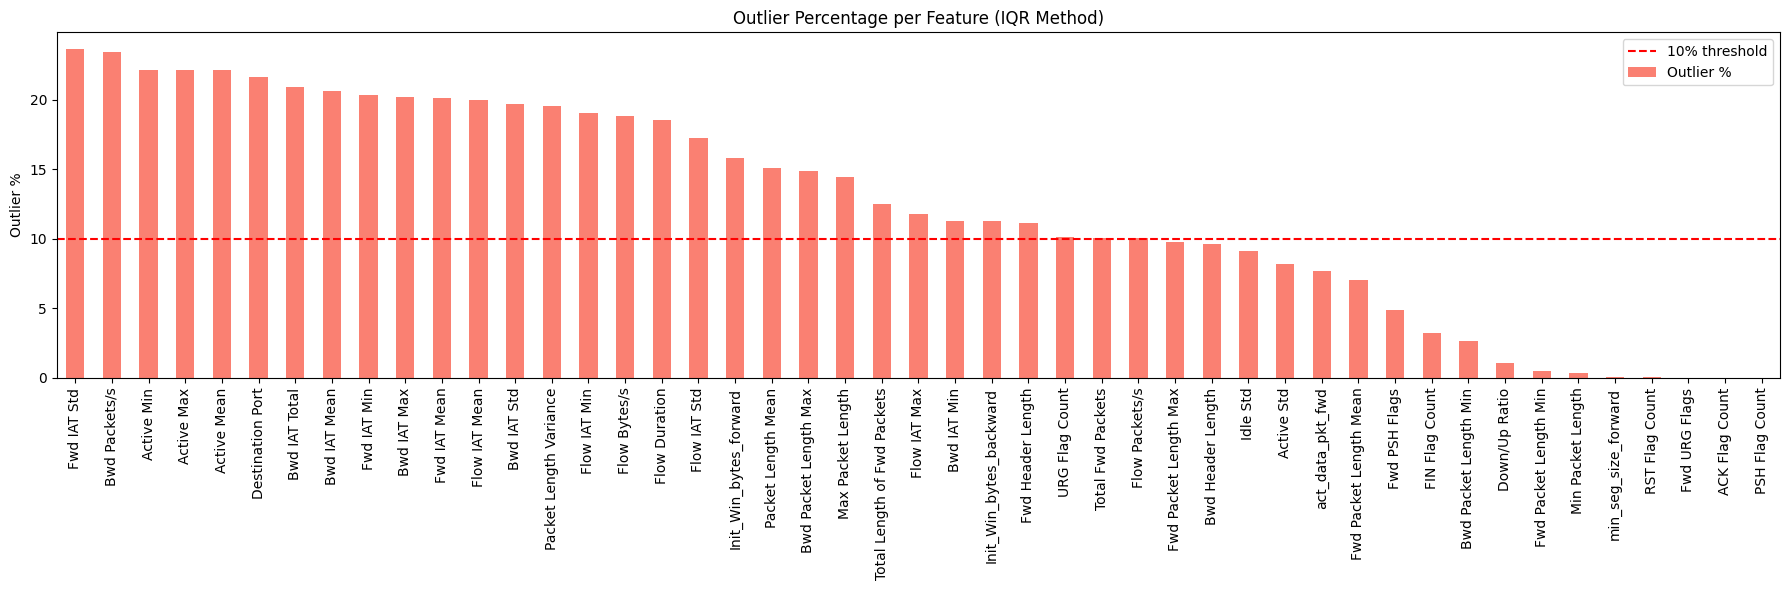


⚠️  30 features have >10% outliers (consider robust scaling):
                             Outlier %
Fwd IAT Std                  23.657989
Bwd Packets/s                23.402391
Active Min                   22.167917
Active Max                   22.167917
Active Mean                  22.167917
Destination Port             21.645137
Bwd IAT Total                20.926819
Bwd IAT Mean                 20.602908
Fwd IAT Min                  20.366311
Bwd IAT Max                  20.187555
Fwd IAT Mean                 20.126462
Flow IAT Mean                19.985512
Bwd IAT Std                  19.700319
Packet Length Variance       19.538899
Flow IAT Min                 19.072649
Flow Bytes/s                 18.840576
Flow Duration                18.572124
Flow IAT Std                 17.236332
Init_Win_bytes_forward       15.797475
Packet Length Mean           15.116170
Bwd Packet Length Max        14.857556
Max Packet Length            14.466839
Total Length of Fwd Packets  12.507979
F

In [8]:
numeric_features, _ = get_feature_types(data)
outlier_pcts = calculate_outliers_percentage(data[numeric_features])
outliers_df = pd.DataFrame.from_dict(outlier_pcts, orient='index', columns=['Outlier %']).sort_values('Outlier %', ascending=False)

plt.figure(figsize=(18, 6))
outliers_df.plot(kind='bar', legend=False, figsize=(18, 6), color='salmon')
plt.axhline(y=10, color='r', linestyle='--', label='10% threshold')
plt.ylabel('Outlier %')
plt.title('Outlier Percentage per Feature (IQR Method)')
plt.legend()
plt.tight_layout()
plt.show()

high_outlier = outliers_df[outliers_df['Outlier %'] > 10]
print(f"\n⚠️  {len(high_outlier)} features have >10% outliers (consider robust scaling):"  )
print(high_outlier)

## 9. Label Encoding & Feature Scaling

- **Label Encoding** — Convert the `Attack Type` target to integer labels.
- **Standard Scaling** — Scale all numeric features to zero mean and unit variance, which is required for many ML algorithms (SVM, KNN, Neural Networks, PCA, etc.).

In [9]:
# 9.1 Label Encoding
label_encoder = LabelEncoder()
data['Attack Type'] = label_encoder.fit_transform(data['Attack Type'])

print("Label mapping:")
for idx, label in enumerate(label_encoder.classes_):
    count = (data['Attack Type'] == idx).sum()
    print(f"  {idx} → {label}  ({count:,} samples)")

# 9.2 Separate features and target
target_col = 'Attack Type'
X = data.drop(columns=[target_col])
y = data[target_col]

# 9.3 Standard Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

print(f"\n✅ Features shape: {X_scaled.shape}")
print(f"✅ Target shape:   {y.shape}")
X_scaled.head()

Label mapping:
  0 → Bots  (1,948 samples)
  1 → Brute Force  (9,150 samples)
  2 → DDoS  (128,014 samples)
  3 → DoS  (193,745 samples)
  4 → Normal Traffic  (2,095,057 samples)
  5 → Port Scanning  (90,694 samples)
  6 → Web Attack � Brute Force  (1,470 samples)
  7 → Web Attack � Sql Injection  (21 samples)
  8 → Web Attack � XSS  (652 samples)

✅ Features shape: (2520751, 47)
✅ Target shape:   (2520751,)

✅ Features shape: (2520751, 47)
✅ Target shape:   (2520751,)


,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,...,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Std
0,-0.436637,2.739180,0.047510,0.895762,0.227156,-0.315858,0.705262,-0.025477,3.849311,-0.053086,...,-1.006884,-0.458603,-0.016779,0.025212,0.002709,0.163971,1.272798,1.343429,-0.106519,0.761585
1,-0.436637,2.749916,0.072687,1.063418,0.227156,-0.315858,0.529865,0.080502,1.168731,-0.053085,...,-1.006884,-0.471002,-0.016555,0.048937,0.002709,0.126560,1.098796,1.154555,-0.106608,0.751711
2,-0.457096,2.933611,0.175912,-0.059957,-0.305693,-0.315858,-0.324733,-0.478338,-0.608918,-0.053093,...,-1.006884,-0.497786,-0.249845,-0.008893,0.002681,9.940966,28.004244,18.649152,-0.107130,4.869709
3,-0.433796,1.239565,-0.001585,0.170372,1.139478,-0.315858,0.999161,0.237997,-0.608918,-0.053089,...,-1.006884,0.063453,-0.192251,0.002970,0.002698,-0.133439,-0.110943,-0.158520,-0.107140,-0.116063
4,-0.454309,-0.470888,-0.010397,-0.049874,-0.238261,0.522974,-0.063932,-0.399345,1.662522,0.006228,...,0.430595,-0.497786,-0.249845,-0.007410,0.002709,-0.133439,-0.110943,-0.158520,-0.107140,-0.116063


## 10. Train / Test Split

Stratified split to preserve class proportions — **70% train, 30% test**.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"X_train: {X_train.shape}   y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}   y_test:  {y_test.shape}")

# Verify stratification
print("\nClass distribution in train set:")
print(y_train.value_counts(normalize=True).round(4))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True).round(4))

X_train: (1764525, 47)   y_train: (1764525,)
X_test:  (756226, 47)   y_test:  (756226,)

Class distribution in train set:
Attack Type
4    0.8311
3    0.0769
2    0.0508
5    0.0360
1    0.0036
0    0.0008
6    0.0006
8    0.0003
7    0.0000
Name: proportion, dtype: float64

Class distribution in test set:
Attack Type
4    0.8311
3    0.0769
2    0.0508
5    0.0360
1    0.0036
0    0.0008
6    0.0006
8    0.0003
7    0.0000
Name: proportion, dtype: float64


## 11. Export Cleaned Dataset

Save the fully preprocessed dataset to a CSV file for downstream model training.

In [11]:
OUTPUT_DIR = 'data_out'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save the cleaned (unscaled) dataset with labels
data.to_csv(os.path.join(OUTPUT_DIR, 'cicids2017_cleaned.csv'), index=False)

# Save the scaled train/test splits
X_train.to_csv(os.path.join(OUTPUT_DIR, 'X_train.csv'), index=False)
X_test.to_csv(os.path.join(OUTPUT_DIR, 'X_test.csv'), index=False)
y_train.to_csv(os.path.join(OUTPUT_DIR, 'y_train.csv'), index=False)
y_test.to_csv(os.path.join(OUTPUT_DIR, 'y_test.csv'), index=False)

print(f"✅ Exported files to '{OUTPUT_DIR}/':")
for f in os.listdir(OUTPUT_DIR):
    if f.endswith('.csv'):
        size_mb = os.path.getsize(os.path.join(OUTPUT_DIR, f)) / (1024 * 1024)
        print(f"  📄 {f}  ({size_mb:.1f} MB)")

✅ Exported files to 'data_out/':
  📄 cicids2017_cleaned.csv  (522.9 MB)
  📄 y_train.csv  (3.4 MB)
  📄 y_test.csv  (1.4 MB)
  📄 X_train.csv  (1623.9 MB)
  📄 X_test.csv  (696.0 MB)


## 12. Summary

| Step | Action | Source Notebook |
|------|--------|-----------------|
| Load & Merge | Walk directory, concat all CSVs | comprehensive |
| Column Cleaning | Strip whitespace from names | comprehensive + SafeML |
| Duplicate Removal | `drop_duplicates()` | comprehensive |
| Identical Column Removal | Compare column pairs | comprehensive |
| Inf/NaN Handling | Replace inf → NaN, dropna | comprehensive + ANN + SafeML |
| Label Grouping | Map 15 attack types → 7 groups | comprehensive |
| Rare Class Removal | Drop Infiltration & Heartbleed | comprehensive |
| Single-value Column Removal | `nunique() == 1` | comprehensive |
| High Correlation Removal | \|r\| ≥ 0.95 upper-triangle | comprehensive |
| Feature Importance | Kruskal-Wallis H-test | comprehensive |
| Outlier Analysis | IQR method (informational) | comprehensive |
| Label Encoding | `LabelEncoder` | ANN |
| Scaling | `StandardScaler` | ANN + SafeML |
| Train/Test Split | 70/30 stratified | ANN + SafeML |
| Export | CSV files to `data/` | comprehensive |

---
**Next Steps:** Use the exported train/test CSVs for model training (ANN, Random Forest, KNN, etc.).